In [377]:
import io
from collections import defaultdict
import random

import chess
import chess.pgn
import chess.engine

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [27]:
from analysis_utils import get_first_move_with_bad_move, get_all_losses_for_my_moves, get_move
from local_data_manager import get_all_games

In [21]:
games = get_all_games('chessprimes', None, download=False, parse=False, analysis_time=0.25)

In [22]:
def get_total_number_moves(game):
    i = 0
    while len(game.variations):
        i += 1
        game = game.variations[0]
    return i

In [23]:
num_moves = list(map(get_total_number_moves, games))

In [24]:
print(f"on average total half moves is {sum(num_moves)/len(num_moves)}")

on average total half moves is 71.10741510741511


In [34]:
games[31].headers

Headers(Event='?', Site='https://lichess.org/2K0M7VUD', Date='2021-01-02 21:51:24.261000+00:00', Round='?', White='ziata', Black='chessprimes', Result='*')

-301


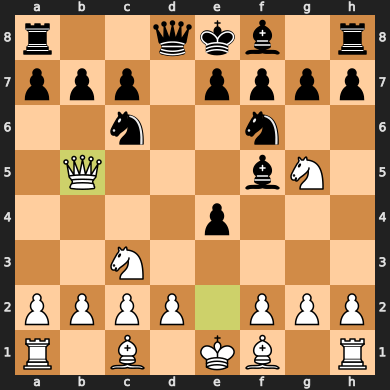

In [41]:
game = games[31]
move_num = 11
move = get_move(game, move_num)
print(move.eval())
move.board()

In [123]:
moves = []
diffs = []
checkmate_moves = []
no_data_moves = []
for i, game in enumerate(games):
    move_num, diff = get_first_move_with_bad_move(game, 'chessprimes', min_rating=-175, max_rating=175)
    if diff is None:
        no_data_moves.append(i)
        continue
    if diff == float('inf'):
        checkmate_moves.append(i)
        continue
    moves.append(move_num // 2 if move_num % 2 == 0 else move_num // 2 + 1)
    diffs.append(diff)

In [125]:
print(f"On average I lose {sum(diffs)/len(diffs)} to go into a bad position on my {sum(moves)/len(moves)}'th move'")

On average I lose 245.0403162055336 to go into a bad position on my 13.793675889328064'th move'


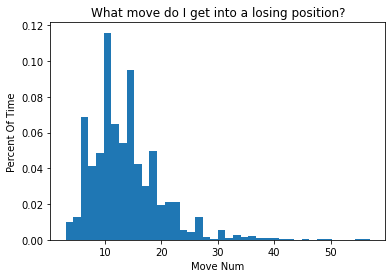

In [138]:
plt.hist(moves, density=True, bins=40)  # density=False would make counts
plt.ylabel('Percent Of Time')
plt.xlabel('Move Num')
plt.title("What move do I get into a losing position?")
plt.savefig('percent_move_losing.png')

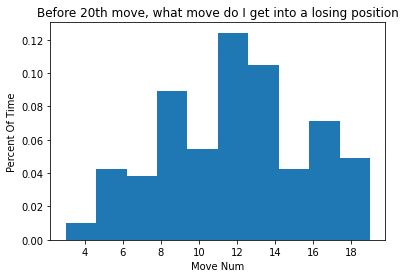

In [132]:
plt.hist(list(filter(lambda m: m < 20, moves)), density=True, bins=10)  # density=False would make counts
plt.ylabel('Percent Of Time')
plt.xlabel('Move Num')
plt.title("Before 20th move, what move do I get into a losing position");

In [192]:
d_set = defaultdict(list)
for move_num, diff in zip(moves, diffs):
    d_set[move_num].append(diff)
datas = []
for move_num, idv_diffs in d_set.items():
    datas.append(
        {
            'move_num': move_num,
            'avg_loss': sum(idv_diffs)/len(idv_diffs),
            'total_moves': len(idv_diffs)
        }
    )

In [193]:
data = pd.DataFrame(datas).sort_values(by='move_num')

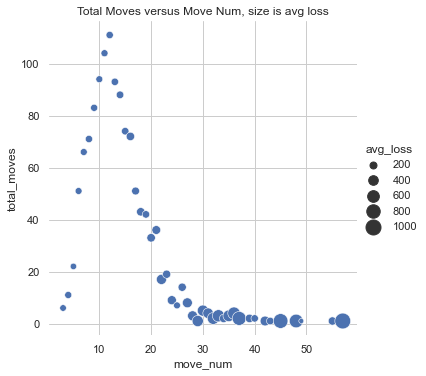

In [194]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=data,
    x="move_num", y="total_moves",
    size="avg_loss",
    palette=cmap, sizes=(25, 250),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Total Moves versus Move Num, size is avg loss')
plt.savefig('images/replotavg_total_moves_versus_move_num.png');

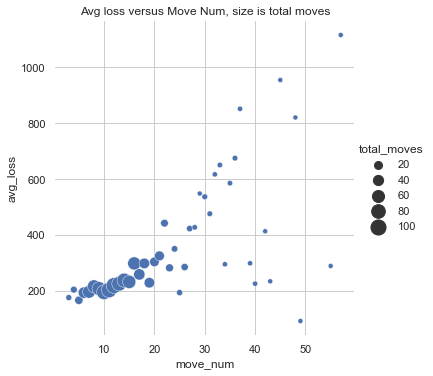

In [195]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=data,
    x="move_num", y="avg_loss",
    size="total_moves",
    palette=cmap, sizes=(25, 250),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Avg loss versus Move Num, size is total moves')
plt.savefig('images/replotavg_loss_versus_move_num.png');

In [183]:
game.headers

Headers(Event='?', Site='https://lichess.org/i2KnIEpr', Date='2018-12-04 18:07:47.168000+00:00', Round='?', White='chessprimes', Black='syolcu', Result='*')

In [442]:
for i, game in enumerate(games):
    for move_num, loss in get_all_losses_for_my_moves(game, 'chessprimes'):
        move_num = move_num // 2 if move_num % 2 == 0 else move_num // 2 + 1
        if loss < -8000:
            print(i, move_num, loss)
            break

263 62 -8723
281 42 -8149
1386 39 -8333


In [463]:
games[263].headers

Headers(Event='?', Site='https://lichess.org/Zxa2vFdg', Date='2020-11-29 15:20:32.720000+00:00', Round='?', White='lolcuneo', Black='chessprimes', Result='*', BlackRating='1876', BlackRatingDiff='-5', ClockIncr='2', ClockInitial='180', ClockTotal='260', ID='Zxa2vFdg', Perf='blitz', Speed='blitz', Status='resign', WhiteRating='1906', WhiteRatingDiff='5', playing_white=False)

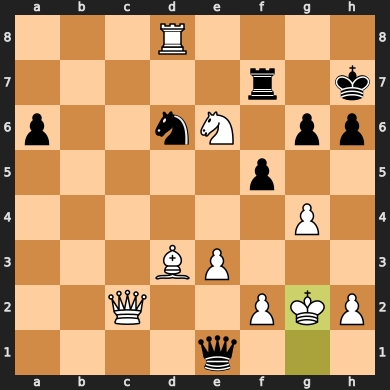

In [441]:
get_move(games[3], 63).board()

In [467]:
data_buckets = defaultdict(list)
data_buckets_inf = defaultdict(int)
for game in games:
    for move_num, loss in get_all_losses_for_my_moves(game, 'chessprimes'):
        move_num = move_num // 2 if move_num % 2 == 0 else move_num // 2 + 1
        if loss == float('inf') or loss < -2500:
            data_buckets_inf[move_num] += 1
        else:
            data_buckets[move_num].append(loss if loss >= 20 else 0)  # appending zero for near-perfect moves, especially because analysis was only 0.25 seconds
        
datas = []
for move_num, losses in data_buckets.items():
    datas.append({
        'move_num': move_num,
        'avg_loss': sum(losses)/len(losses),
        'total_moves': len(losses)
    })
datas = pd.DataFrame(datas)
datas_inf = []
for move_num, num_losses in data_buckets_inf.items():
    datas_inf.append({
        'move_num': move_num,
        'avg_loss': float('inf'),
        'total_moves': num_losses
    })
datas_inf = pd.DataFrame(datas_inf)

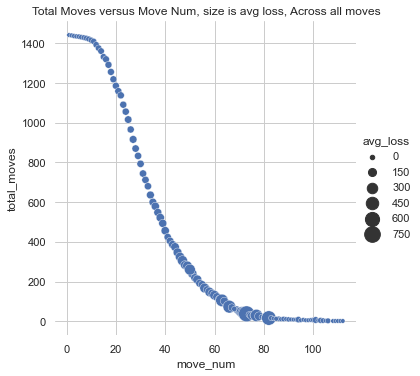

In [468]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=datas,
    x="move_num", y="total_moves",
    size="avg_loss",
    palette=cmap, sizes=(20, 250),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Total Moves versus Move Num, size is avg loss, Across all moves')
plt.savefig('images/replotavg_total_moves_versus_move_num_all_moves_loss.png');

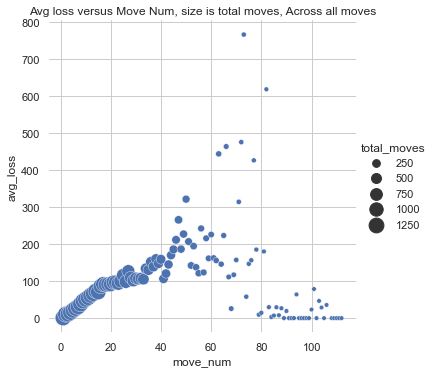

In [469]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=datas,
    x="move_num", y="avg_loss",
    size="total_moves",
    palette=cmap, sizes=(20, 250),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Avg loss versus Move Num, size is total moves, Across all moves')
plt.savefig('images/replotavg_avg_loss_versus_move_num_all_moves.png');

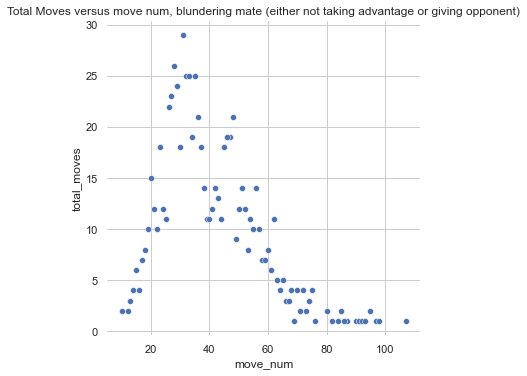

In [470]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=datas_inf,
    x="move_num", y="total_moves",
#     size="total_moves",
    palette=cmap, sizes=(20, 250),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Total Moves versus move num, blundering mate (either not taking advantage or giving opponent)')
plt.savefig('images/blundering_mate.png'); 

In [471]:
games[0].headers._others

{'BlackRating': '1928',
 'BlackRatingDiff': '0',
 'ClockIncr': '2',
 'ClockInitial': '180',
 'ClockTotal': '260',
 'ID': 'bB1gKq4J',
 'Perf': 'blitz',
 'Speed': 'blitz',
 'Status': 'draw',
 'WhiteRating': '1901',
 'WhiteRatingDiff': '0',
 'playing_white': False}

In [475]:
user_id = 'chessprimes'
data_rows = []
for game in games:
    base_data = game.headers._others
    base_data['playing_white'] = game.headers['White'] == user_id
    for move_num, loss in get_all_losses_for_my_moves(game, user_id):
        move_num = move_num // 2 if move_num % 2 == 0 else move_num // 2 + 1
        data_row = {
            'move_num': move_num,
            'loss': loss,
            'playing_white': game.headers 
        }
        data_row.update(base_data)
        data_rows.append(data_row)
df = pd.DataFrame(data_rows)
df['loss'] = df[['loss']].apply(lambda x: x['loss'] if x['loss'] > -1000 else float('inf'), axis=1)

In [476]:
df['loss'].describe()

count   50573.00000
mean            inf
std             nan
min      -965.00000
25%         0.00000
50%        20.00000
75%        78.00000
max             inf
Name: loss, dtype: float64

In [244]:
df.apply(lambda x: x['BlackRating'] == str(1928), axis=1)

,move_num,loss,playing_white,BlackRating,BlackRatingDiff,ClockIncr,ClockInitial,ClockTotal,ID,Perf,Speed,Status,WhiteRating,WhiteRatingDiff
0,1,0.0,False,1928,0,2,180,260,bB1gKq4J,blitz,blitz,draw,1901,0
1,2,-8.0,False,1928,0,2,180,260,bB1gKq4J,blitz,blitz,draw,1901,0
2,3,31.0,False,1928,0,2,180,260,bB1gKq4J,blitz,blitz,draw,1901,0
3,4,-5.0,False,1928,0,2,180,260,bB1gKq4J,blitz,blitz,draw,1901,0
4,5,-19.0,False,1928,0,2,180,260,bB1gKq4J,blitz,blitz,draw,1901,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50568,19,142.0,True,1521,7,0,180,180,i2KnIEpr,blitz,blitz,resign,1500,-165
50569,20,inf,True,1521,7,0,180,180,i2KnIEpr,blitz,blitz,resign,1500,-165
50570,21,inf,True,1521,7,0,180,180,i2KnIEpr,blitz,blitz,resign,1500,-165
50571,22,34.0,True,1521,7,0,180,180,i2KnIEpr,blitz,blitz,resign,1500,-165


In [298]:
def group_it_by(df, colname, aggs, f):
    tmp = df.copy()
    tmp[colname] = df.apply(f, axis=1)
    tmp2 = tmp[['move_num', 'loss', colname]].groupby(colname, as_index=False).apply(lambda x: x.reset_index(drop=True)).reset_index()[['move_num', 'loss', colname]]
    tmp3 = tmp2.groupby('move_num').agg({
        'loss': ['count', 'mean'],
        colname: aggs
    }).reset_index()
    tmp3.columns = ['_'.join(filter(None, col)) for col in tmp3.columns]
    return tmp3

In [311]:
colname = 'playing_against_higher_rated'
f = lambda x: int(int(x['BlackRating']) > int(x['WhiteRating'])) if x['playing_white'] else int(int(x['WhiteRating']) > int(x['BlackRating']))
tmp = df[df['loss'] != float('inf')].copy()
tmp[colname] = df.apply(f, axis=1)

In [487]:
def get_data1(df, colname, f, apply_loss_n=0, remove_loss_zero=False):
    tmp = df[df['loss'] != float('inf')].copy()
    tmp['loss'] = tmp.apply(lambda x: x['loss'] if abs(x['loss']) > apply_loss_n else 0, axis=1)
    if remove_loss_zero:
        tmp = tmp[tmp['loss'] != 0]
    tmp[colname] = df.apply(f, axis=1)
    tmp2 = tmp[['move_num', 'loss', colname]].groupby([colname, 'move_num'], as_index=False).agg({
        'loss': ['count', 'mean'],
    })
    tmp2.columns = ['_'.join(filter(None, col)) for col in tmp2.columns]
    return tmp2

In [ ]:
c = df.groupby(['state', 'office_id'])['sales'].sum().rename("count")
def get_data2(df, colname, f, apply_loss_n=0, remove_loss_zero=False):
    tmp = df[df['loss'] != float('inf')].copy()
    tmp['loss'] = tmp.apply(lambda x: x['loss'] if abs(x['loss']) > apply_loss_n else 0, axis=1)
    if remove_loss_zero:
        tmp = tmp[tmp['loss'] != 0]
    tmp[colname] = df.apply(f, axis=1)
    tmp2 = tmp[['move_num', 'loss', colname]].groupby([colname, 'move_num'], as_index=False).agg({
        'loss': ['count', 'mean'],
    })
    tmp2.columns = ['_'.join(filter(None, col)) for col in tmp2.columns]
    return tmp2

In [478]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [412]:
tmp = df[df['loss'] != float('inf')]
tmp = tmp[tmp['loss'] < -100]
tmp['loss'].describe()

count     467.00000
mean     -833.50107
std      1536.54004
min     -8723.00000
25%      -564.00000
50%      -204.00000
75%      -127.00000
max      -101.00000
Name: loss, dtype: float64

/Users/kennethgoodman/venv/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


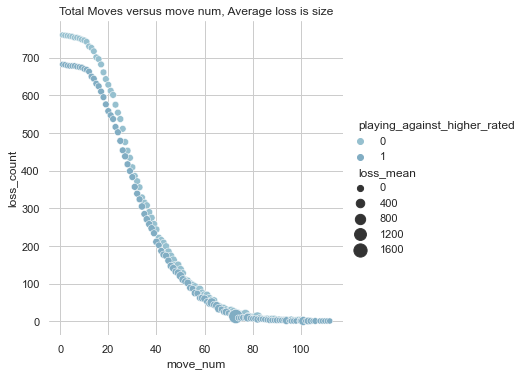

In [483]:
col = 'playing_against_higher_rated'
f = lambda x: int(int(x['BlackRating']) > int(x['WhiteRating'])) if x['playing_white'] else int(int(x['WhiteRating']) > int(x['BlackRating']))
data = get_data1(df, col, f, apply_loss_n=20)

sns.set_theme(style="whitegrid")


cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
hue = 'playing_against_higher_rated'
total_num_hue = len(set(tmp2[hue].values))
g = sns.relplot(
    data=data,
    x="move_num", y="loss_count",
    size="loss_mean", hue="playing_against_higher_rated",
    palette=cmap.colors[random.sample(range(256), total_num_hue)], sizes=(10, 200),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Total Moves versus move num, Average loss is size')
plt.savefig('images/total_move_versus_move_num_with_hue_for_higher_lower_rated.png'); 

/Users/kennethgoodman/venv/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


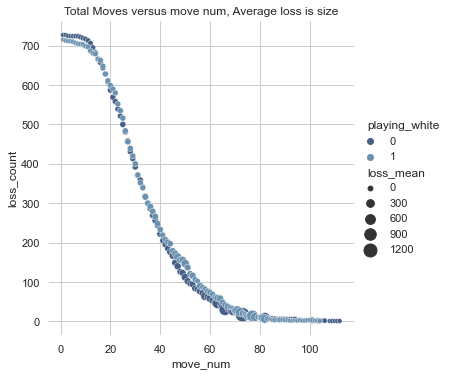

In [492]:
col = 'playing_white'
f = lambda x: int(x['playing_white'])
data = get_data1(df, col, f, apply_loss_n=20)

sns.set_theme(style="whitegrid")


cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
hue = 'playing_against_higher_rated'
total_num_hue = len(set(tmp2[hue].values))
g = sns.relplot(
    data=data,
    x="move_num", y="loss_count",
    size="loss_mean", hue="playing_white",
    palette=cmap.colors[random.sample(range(256), total_num_hue)], sizes=(10, 200),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Total Moves versus move num, Average loss is size')
plt.savefig('images/total_move_versus_move_num_with_hue_playing_white.png'); 

In [493]:
df

,move_num,loss,playing_white,BlackRating,BlackRatingDiff,ClockIncr,ClockInitial,ClockTotal,ID,Perf,Speed,Status,WhiteRating,WhiteRatingDiff
0,1,0.00000,False,1928,0,2,180,260,bB1gKq4J,blitz,blitz,draw,1901,0
1,2,-8.00000,False,1928,0,2,180,260,bB1gKq4J,blitz,blitz,draw,1901,0
2,3,31.00000,False,1928,0,2,180,260,bB1gKq4J,blitz,blitz,draw,1901,0
3,4,-5.00000,False,1928,0,2,180,260,bB1gKq4J,blitz,blitz,draw,1901,0
4,5,-19.00000,False,1928,0,2,180,260,bB1gKq4J,blitz,blitz,draw,1901,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50568,19,142.00000,True,1521,7,0,180,180,i2KnIEpr,blitz,blitz,resign,1500,-165
50569,20,inf,True,1521,7,0,180,180,i2KnIEpr,blitz,blitz,resign,1500,-165
50570,21,inf,True,1521,7,0,180,180,i2KnIEpr,blitz,blitz,resign,1500,-165
50571,22,34.00000,True,1521,7,0,180,180,i2KnIEpr,blitz,blitz,resign,1500,-165


In [529]:
data

,game_mode,move_num,loss_count,loss_mean
0,blitz,1,1387,-10.41817
1,blitz,2,1385,9.59278
2,blitz,3,1382,10.30101
3,blitz,4,1380,14.72464
4,blitz,5,1379,20.37781
...,...,...,...,...
303,rapid,81,1,0.00000
304,rapid,82,1,0.00000
305,rapid,83,1,0.00000
306,rapid,84,1,0.00000


Text(0.5, 1.0, 'Total Moves versus move num, Average loss is size')

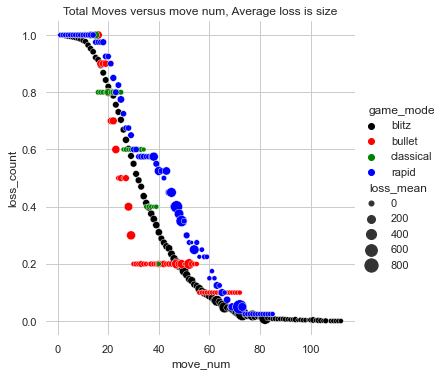

In [539]:
col = 'game_mode'
f = lambda x: x['Speed']
data = get_data1(df, col, f, apply_loss_n=20)

sns.set_theme(style="whitegrid")
g = data.groupby(['game_mode']).agg({'loss_count': 'max'}).reset_index()
d = dict(zip(g['game_mode'],g['loss_count'])) 
data['loss_count'] = data.apply(lambda x: x['loss_count'] / d[x['game_mode']], axis=1)

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
hue = 'game_mode'
total_num_hue = len(set(data[hue].values))
g = sns.relplot(
    data=data,
    x="move_num", y="loss_count",
    size="loss_mean", hue="game_mode",
    palette=['black', 'red', 'green', 'blue'], sizes=(10, 200),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Total Moves versus move num, Average loss is size')
# plt.savefig('images/total_move_versus_move_num_with_hue_playing_white.png'); 

In [ ]:
# hue = win/loss

In [ ]:
# hue = innaccuracy/mistake/blunder

In [ ]:
tmp2

/Users/kennethgoodman/venv/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


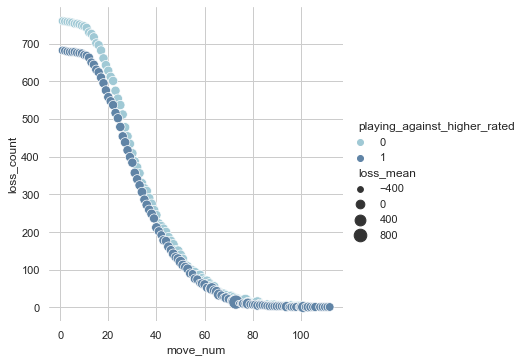

In [376]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Load the example planets dataset
planets = sns.load_dataset("planets")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
hue = 'playing_against_higher_rated'
total_num_hue = len(set(tmp2[hue].values))
g = sns.relplot(
    data=tmp2,
    x="move_num", y="loss_count",
    size="loss_mean", hue="playing_against_higher_rated",
    palette=cmap.colors[random.sample(range(256), total_num_hue)], sizes=(10, 200),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)

In [374]:
cmap.colors[random.sample(range(256), total_num_hue)]

array([[0.48771693, 0.65585136, 0.7492622 , 1.        ],
       [0.13361721, 0.15514876, 0.26510382, 1.        ]])

In [361]:
set(tmp2['playing_against_higher_rated'].values)

{0, 1}

In [342]:
planets['year']

0       2006
1       2008
2       2011
3       2007
4       2009
        ... 
1030    2006
1031    2007
1032    2007
1033    2008
1034    2008
Name: year, Length: 1035, dtype: int64

In [345]:
tmp2['playing_against_higher_rated']

0      0
1      0
2      0
3      0
4      0
      ..
212    1
213    1
214    1
215    1
216    1
Name: playing_against_higher_rated, Length: 217, dtype: int64